# Chargement des modules 

In [1]:
# Import necessary libraries
import mne
import matplotlib.pyplot as plt
import matplotlib
import os 
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

# Set plot style
sns.set(style='whitegrid')
%matplotlib inline
#from mne.preprocessing import ICA
#from mne.channels import make_standard_montage
#from mne_icalabel import label_components  # Ensure ICLabel is installed: pip install mne-icalabel

import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Visualisation 

In [6]:
# Path to the GNG pre process data file
fif_path = r'/Users/keke/Desktop/sub-01_ses-001_raw_preprocessed_GonoGo_noEpoched.fif'  # Update with your actual file path

# Load the GNG pre process data
raw = mne.io.read_raw_fif(fif_path, preload=True)

# Display information about the pre process data
print(raw.info)


Opening raw data file /Users/keke/Desktop/sub-01_ses-001_raw_preprocessed_GonoGo_noEpoched.fif...
    Range : 81028 ... 385484 =    270.093 ...  1284.947 secs
Ready.
Reading 0 ... 304456  =      0.000 ...  1014.853 secs...
<Info | 11 non-empty values
 bads: []
 ch_names: P3, C3, F3, Fz, F4, C4, P4, Cz, Fp1, Fp2, T3, T5, O1, O2, F7, ...
 chs: 18 EEG, 2 misc, 1 Stimulus
 custom_ref_applied: False
 dig: 21 items (3 Cardinal, 18 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2024-11-27 11:27:48 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 300.0 Hz
 subject_info: 4 items (dict)
>


In [7]:
# Define the event IDs based on the trigger list
event_id = {
    'Go': 1,
    'NoGo': 2,
    'Correct': 3,
    'Incorrect': 4
}

# Replace 'STI 014' with your actual stimulus channel name if different
events = mne.find_events(raw, stim_channel='Trigger')

# Display the first few events
print(events[:10])
# Initialize lists to store new events and their IDs
new_events = []
new_event_id = {
    'Go_Correct': 101,
    'Go_Incorrect': 102,
    'NoGo_Correct': 201,
    'NoGo_Incorrect': 202
}

# Iterate through events to combine onset and response triggers
i = 0
while i < len(events) - 1:
    onset_event = events[i]
    response_event = events[i + 1]
    
    onset = onset_event[2]
    response = response_event[2]
    
    # Check if the current event is an onset trigger and the next is a response trigger
    if onset in [1, 2] and response in [3, 4]:
        if onset == 1 and response == 3:
            new_events.append([onset_event[0], 0, new_event_id['Go_Correct']])
        elif onset == 1 and response == 4:
            new_events.append([onset_event[0], 0, new_event_id['Go_Incorrect']])
        elif onset == 2 and response == 3:
            new_events.append([onset_event[0], 0, new_event_id['NoGo_Correct']])
        elif onset == 2 and response == 4:
            new_events.append([onset_event[0], 0, new_event_id['NoGo_Incorrect']])
        # Skip the response event in the next iteration
        i += 2
    else:
        # If not a valid onset-response pair, skip to the next event
        i += 1

# Convert to numpy array
new_events = np.array(new_events)

# Display the first few new events
print(new_events[:10])


Trigger channel has a non-zero initial value of 7 (consider using initial_event=True to detect this event)
1198 events found
Event IDs: [1 2 3 4 8 9]
[[81043     7     8]
 [81636     0     2]
 [82826     0     3]
 [82982     0     1]
 [83194     0     1]
 [83490     0     3]
 [83648     0     1]
 [83821     0     1]
 [84117     0     3]
 [84276     0     1]]
[[81636     0   201]
 [83194     0   101]
 [83821     0   101]
 [84409     0   101]
 [84865     0   201]
 [86346     0   101]
 [86927     0   101]
 [87498     0   101]
 [88848     0   201]
 [89438     0   101]]


Not setting metadata
396 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 396 events and 301 original time points ...
0 bad epochs dropped
<Epochs |  396 events (all good), -0.2 - 0.8 sec, baseline -0.2 – 0 sec, ~19.1 MB, data loaded,
 'Go_Correct': 300
 'NoGo_Correct': 96>


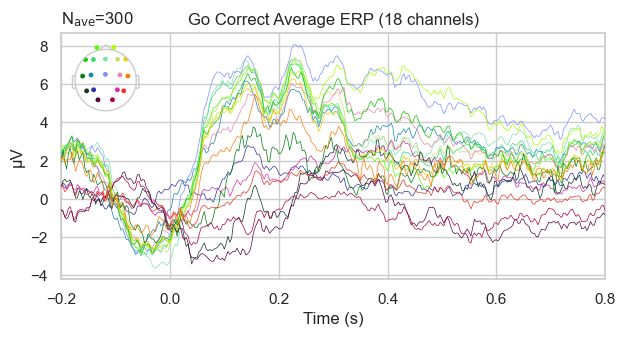

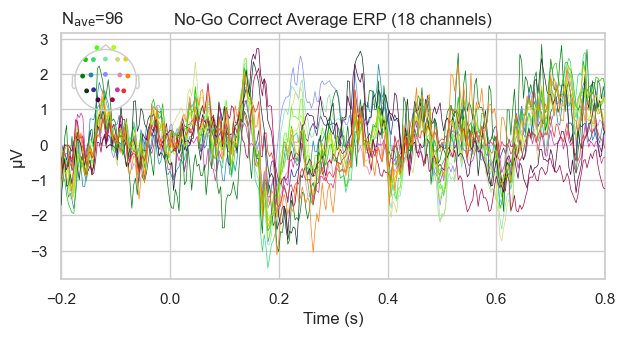

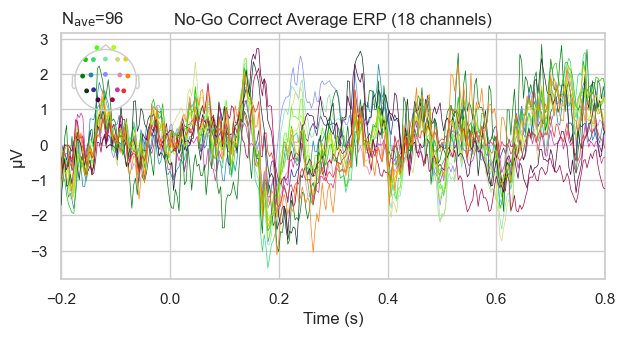

In [8]:
# Define combined event IDs for epoching
combined_event_id = {
    'Go_Correct': 101,
    'NoGo_Correct': 201
}

# Define epoch parameters
tmin = -0.2
tmax = 0.8
baseline = (None, 0)

# Create epochs for correct responses only
epochs_correct = mne.Epochs(raw, new_events, event_id=combined_event_id, tmin=tmin, tmax=tmax,
                            baseline=baseline, preload=True, verbose=True)
print(epochs_correct)

# Plot average ERPs
evoked_go_correct = epochs_correct['Go_Correct'].average()
evoked_go_correct.plot(titles='Go Correct Average ERP', spatial_colors=True)

evoked_nogo_correct = epochs_correct['NoGo_Correct'].average()
evoked_nogo_correct.plot(titles='No-Go Correct Average ERP', spatial_colors=True)


In [12]:
# Define channel names for Middle and Back ROIs 
#(Regions of interest : An ROI is typically a group of electrodes or a particular spatial region on the scalp that corresponds to a brain region of interest, such as the frontal, temporal, parietal, or occipital lobes.)
middle_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'Fz', 'C3', 'C4', 'Cz']
back_channels = ['P3', 'P4', 'O1', 'O2']

# Select channel indices for Middle and Back ROIs
middle_ix = mne.pick_channels(raw.info["ch_names"], include=middle_channels)
back_ix = mne.pick_channels(raw.info["ch_names"], include=back_channels)

# Define a dictionary mapping ROI names to their respective channel indices
roi_dict = {
    'Middle_ROI': middle_ix,
    'Back_ROI': back_ix
}

# Combine channels within each ROI by averaging for Go_Correct condition
roi_evoked_go = mne.channels.combine_channels(epochs_correct['Go_Correct'].average(), roi_dict, method="mean")

# Combine channels within each ROI by averaging for NoGo_Correct condition
roi_evoked_nogo = mne.channels.combine_channels(epochs_correct['NoGo_Correct'].average(), roi_dict, method="mean")

# Display the new channel names to confirm
print("Virtual ROI channels for Go_Correct:", roi_evoked_go.info["ch_names"])
print("Virtual ROI channels for NoGo_Correct:", roi_evoked_nogo.info["ch_names"])

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Virtual ROI channels for Go_Correct: ['Middle_ROI', 'Back_ROI']
Virtual ROI channels for NoGo_Correct: ['Middle_ROI', 'Back_ROI']


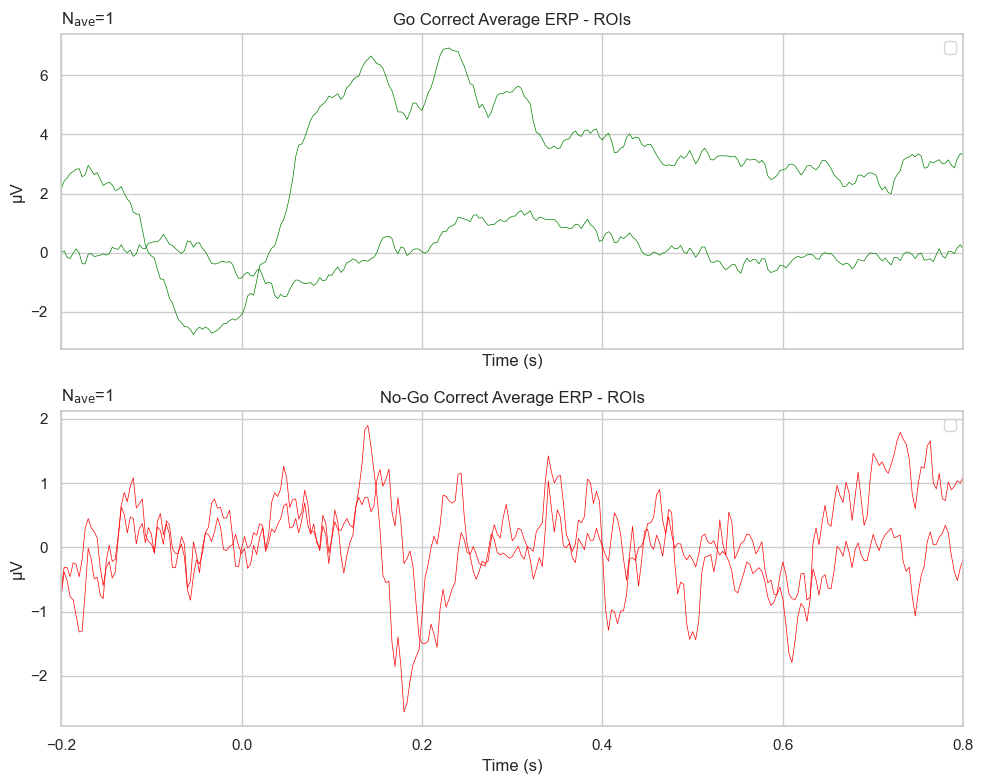

In [13]:
# Create a figure with two subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Go Correct ERP in the top subplot
roi_evoked_go.plot(axes=axes[0], spatial_colors=True, show=False)
axes[0].set_title('Go Correct Average ERP - ROIs')

# Customize line colors to green
for line in axes[0].get_lines():
    line.set_color('green')

# Add legend
handles_go, labels_go = axes[0].get_legend_handles_labels()
axes[0].legend(handles_go, labels_go, loc='upper right')

# Plot No-Go Correct ERP in the bottom subplot
roi_evoked_nogo.plot(axes=axes[1], spatial_colors=True, show=False)
axes[1].set_title('No-Go Correct Average ERP - ROIs')

# Customize line colors to red
for line in axes[1].get_lines():
    line.set_color('red')

# Add legend
handles_nogo, labels_nogo = axes[1].get_legend_handles_labels()
axes[1].legend(handles_nogo, labels_nogo, loc='upper right')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

combining channels using "mean"
combining channels using "mean"


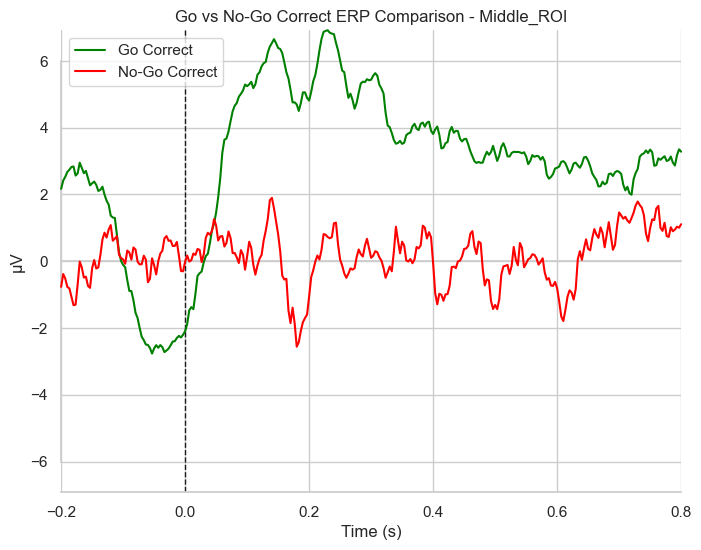

<Figure size 640x480 with 0 Axes>

combining channels using "mean"
combining channels using "mean"


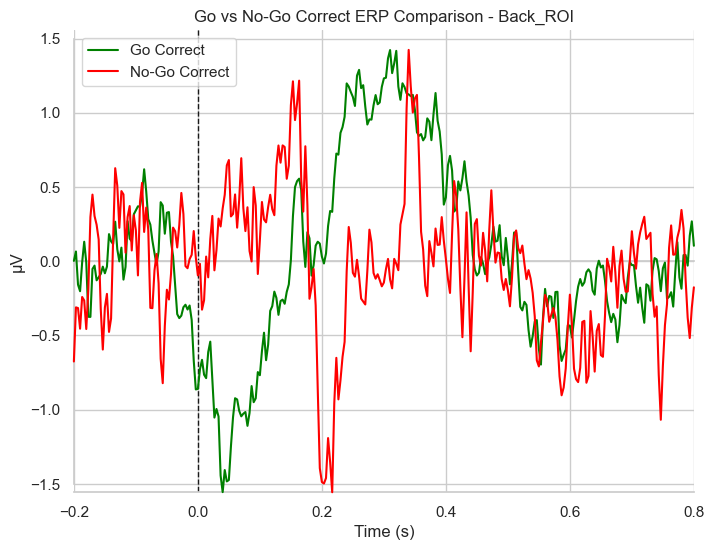

<Figure size 640x480 with 0 Axes>

In [11]:
# Create a dictionary of Evoked objects for comparison
evokeds_compare = {
    'Go Correct': roi_evoked_go,
    'No-Go Correct': roi_evoked_nogo
}

# Define custom colors for each condition
colors_compare = {
    'Go Correct': 'green',
    'No-Go Correct': 'red'
}

# Define the ROIs to include in the comparison
picks_roi = ['Back_ROI']

# Create a figure with subplots for each ROI
mne.viz.plot_compare_evokeds(
    evokeds_compare,
    picks='Middle_ROI',  # Only plot the Back_ROI
    combine='mean',  # Average if multiple channels are present
    colors=colors_compare,
    title=f'Go vs No-Go Correct ERP Comparison - Middle_ROI'
)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
    
# Create a figure with subplots for each ROI
mne.viz.plot_compare_evokeds(
    evokeds_compare,
    picks='Back_ROI',  # Only plot the Back_ROI
    combine='mean',  # Average if multiple channels are present
    colors=colors_compare,
    title=f'Go vs No-Go Correct ERP Comparison - Back_ROI'
)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()